### Autonomous Driving in Airsim: CNN Model




In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import keras
from keras.preprocessing import image
import math
import matplotlib.pyplot as plt
import h5py

In [0]:
INPUT_DATA_PATH =\
"/content/drive/My Drive/AirSim/autonomous_driving/label_smoothing/preprocessed_data_ls/"

MODEL_PATH = "drive/My Drive/AirSim/autonomous_driving/models_reg_tanh_ls/"

In [0]:
train_dataset = h5py.File(INPUT_DATA_PATH + 'train.h5', 'r')
valid_dataset = h5py.File(INPUT_DATA_PATH + 'validation.h5', 'r')
test_dataset  = h5py.File(INPUT_DATA_PATH +  'test.h5', 'r')

In [0]:
# sizes of the datasets: 
print(str(len(train_dataset["image"])) + " training examples")
print(str(len(valid_dataset["image"])) + " validation examples")
print(str(len(test_dataset["image"])) + " test examples")
print()
print()


26568 training examples
2165 validation examples
1860 test examples




In [0]:

# set up the data generators, the data is augmented live

batch_size = 32

from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1./255., brightness_range=(0.3, 1))
data_generator_test_valid = ImageDataGenerator(rescale=1./255.)

def flip_and_roi_gen(generator,  flip_p=0.5, roi =[76,135,0,255]): 
    """
    Data generator for the neural network:
    augment data (brightness, horizontal flip),
    normalize data (divide by 255.)
    cut out roi (region of interest)

    Args:
      generator: keras ImageDataGenerator to rescale and change the brightness
      flip_p: float in [0,1] probability of flipping a training example
      roi: list of 4 ints defining the region of interest


    Yields:
       augmented_images, current steerings
    """
  
  
  
    for img, current_steering in generator: 
      
         # cut out the region of interest
        img= img[:, roi[0]:roi[1], roi[2]:roi[3], :] 
        
         # randomly select images to flip
        flip_selector = np.random.binomial(1, flip_p, size=img.shape[0]) == 1
        
        # flip the images
        img[flip_selector,:,:,:] = img[flip_selector,:,::-1,:] 
        
        # flip the label
        current_steering[flip_selector] = (-1) * current_steering[flip_selector] 


        yield img, current_steering 
        
        
        

train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['current_steering'],
     batch_size=batch_size)

test_generator = data_generator_test_valid.flow\
    (test_dataset['image'], test_dataset['current_steering'],
     batch_size=len(test_dataset["image"]))

valid_generator = data_generator_test_valid.flow\
    (valid_dataset['image'], valid_dataset['current_steering'],
     batch_size=batch_size)

train_gen_flip = flip_and_roi_gen(train_generator,flip_p=0.)    
test_gen = flip_and_roi_gen(test_generator, flip_p=0.)    
valid_gen = flip_and_roi_gen(valid_generator, flip_p=0.)    



In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

In [0]:
# model definition

image_input_shape = sample_batch_X.shape[1:]

image_input = Input(shape=image_input_shape)

stack = Conv2D(20, (3, 3), name="conv0", activation='relu')(image_input)
stack = MaxPooling2D(pool_size=(4,4))(stack)
stack = Conv2D(10, (3, 3), activation='relu', name='conv1')(stack)
stack = MaxPooling2D(pool_size=(4, 4))(stack)
stack = Flatten()(stack)
stack = Dropout(0.2)(stack)
stack = Dense(64, activation='relu', name='dense0')(stack)
stack = Dropout(0.2)(stack)
stack = Dense(10, activation='relu', name='dense1')(stack)
stack = Dropout(0.2)(stack)
stack = Dense(1, name='output', activation = 'tanh')(stack)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=image_input, outputs=stack)

model.compile(optimizer=adam, loss='mse')

In [0]:
# callbacks

plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_PATH, 'model.{0}-{1}.h5'.format('{epoch:02d}', '{val_loss:.7f}'))
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger( MODEL_PATH + 'training_log.csv')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

In [0]:
# model training

num_train_examples = len(train_dataset["image"])
num_eval_examples  = len(valid_dataset["image"])
history = model.fit_generator(train_gen_flip, steps_per_epoch=num_train_examples//batch_size//10, epochs=500, callbacks=callbacks,\
                   validation_data=valid_gen, validation_steps=num_eval_examples//batch_size, verbose=2)

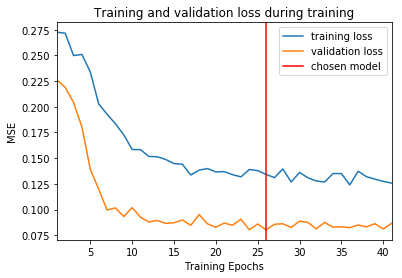

In [0]:
training_log = pd.read_csv(MODEL_PATH + 'training_log.csv')
axes = plt.gca()

plt.plot(training_log["epoch"]+1, training_log["loss"], label = "training loss");
plt.plot(training_log["epoch"]+1, training_log["val_loss"], label = "validation loss");
plt.axvline(x=26, color = "red", label = "chosen model")
axes.set_xlim([1,max(training_log["epoch"]+1)]);
plt.title("Training and validation loss during training")
plt.ylabel('MSE')
plt.xlabel('Training Epochs')

plt.legend();



In [0]:
# evaluate the performance

test_data = next(test_gen)    

prediction = model.predict(test_data[0])
true_label = test_data[1]
baseline_prediction = np.mean(train_dataset["current_steering"])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse_baseline = mean_squared_error(true_label, [baseline_prediction]*len(true_label))

mse_test = mean_squared_error(true_label, prediction)

print("Baseline MSE: " +  str(round(mse_baseline,4)))

print("Test MSE: " +  str(round(mse_test,4)))




Baseline MSE: 0.2556
Test MSE: 0.0991


True Steering: 0.0
Pred. Steering: [-0.55609196]


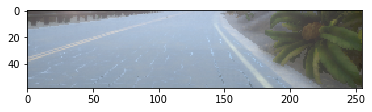




True Steering: 1.0000000000000002
Pred. Steering: [0.73948073]


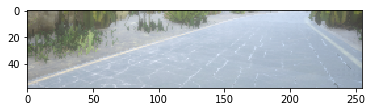




True Steering: 0.7000000000000001
Pred. Steering: [0.29885533]


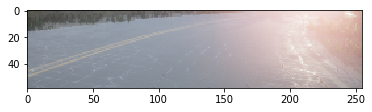

In [0]:
# show some test examples



def plot_image_and_steering(img, current_steering, pred_steering=None):
    """
    Plot an image with the true current steering (left, straight or right)
    and possibly a model prediction of the current steering.

    Args:
        img: numpy array - the image to plot without alpha channel 
        current_steering: int - the label of the true current_steering (-1,0 or 1)
        pred: float - model prediction of the current_steering label in [-1,1]
    Returns:
        None
    """
    
    pil_image = image.array_to_img(img,
                                   keras.backend.image_data_format(),
                                   scale=True)
    
    print('True Steering: {0}'.format(current_steering))
    
    draw_image = pil_image.copy()
    
    image_draw = ImageDraw.Draw(draw_image)

    
    if (pred_steering is not None):

        print('Pred. Steering: {0}'.format(pred_steering))

       
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()
    

for i in range(3):
    plot_image_and_steering(test_data[0][i],  true_label[i], pred_steering = prediction[i])
    print()
    print()
    print()
